# Задание 1
1. Проведите предобработку текстов из файлов positive.csv, negative.csv. Нужно выполнить те же действия, что в предыдущем дне, но не удалять редко встречающиеся слова. Регулировать использование редких слов будем на уровне модели word2vec. Не забудьте удалить стоп-слова.
2. Будем исследовать то, как влияют на качество преобразования *размер целевого векторного пространства* и *использование редких слов*. Создайте несколько моделей word2vec, перебрав параметры:
  - размер результирующего пространства: [10, 300, 500] при фиксированной минимальной встречаемости слов = 10
  - минимальная встречаемость слов: [1, 10, 100] при фиксированном размере результирующего векторного пространства = 300

  Обучите их на всем пространстве текстов.

3. Отберите 5 случайных слов из выборки позитивных публикаций и 5 случайных слови из выборки негативных публикаций.
4. Для каждой из обученных моделей найдите по 15 синонимов и по 15 антонимов для каждого из слов из п.3. Опишите:
  - как влияет размер результирующего пространства на точность определения синонимов/антонимов моделью? почему?
  - как влияет минимальная встречаемость слов на точность определения синонимов/антонимов моделью? почему?
5. Постройте графики распределения слов в двумерном пространстве. Опишите, как влияют исследуемые параметры на кучность и расположение точек на графике. Почему?
6. Возьмите любой твит, обучите модель word2vec с параметрами по умолчанию и попробуйте предсказать продолжение твита. Также попробуйте предсказать продолжение случайной фразы. Сравните результаты, полученные после обучения моделей с разным количеством эпох обучения.

# Решение задания 1

## Приведем данные в нужный вид

In [1]:
!pip install pymorphy2 nltk
import nltk
nltk.download("punkt")
nltk.download("stopwords")

!pip install gensim

from google.colab import drive
import os
# drive.mount('/content/drive/')
drive.mount("/content/drive/", force_remount=True)

import pandas as pd

df_p = pd.read_csv(('/content/drive/MyDrive/Pyton/positive.csv'), header = None, names = ['id', 'date', 'name', 'text', 'positive', 'rep', 'rtv', 'fav', 'total_count', 'fol', 'friends', 'list_count'], sep = ';', index_col=False)
df_n = pd.read_csv(('/content/drive/MyDrive/Pyton/negative.csv'), header = None, names = ['id', 'date', 'name', 'text', 'positive', 'rep', 'rtv', 'fav', 'total_count', 'fol', 'friends', 'list_count'], sep = ';', index_col=False)

df = pd.concat([df_p, df_n], axis=0) # Соединим два датафрейма
df.index = list(range(226834)) # Сделаем сквозную нумерецию
df.positive[df.positive==-1]=0 # Заменим признак негативных высказываний на 0


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Mounted at /content/drive/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [2]:
df

,id,date,name,text,positive,rep,rtv,fav,total_count,fol,friends,list_count
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1
...,...,...,...,...,...,...,...,...,...,...,...,...
226829,425138243257253888,1390195830,Yanch_96,Но не каждый хочет что то исправлять:( http://...,0,0,0,0,1138,32,46,0
226830,425138339503943682,1390195853,tkit_on,скучаю так :-( только @taaannyaaa вправляет мо...,0,0,0,0,4822,38,32,0
226831,425138437684215808,1390195876,ckooker1,"Вот и в школу, в говно это идти уже надо(",0,0,0,1,165,13,16,0
226832,425138490452344832,1390195889,LisaBeroud,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",0,0,1,0,2516,187,265,0


## Проведем предобработку текстов

In [ ]:
# Приведем весь текст к строчным буквам

df.text = df.text.str.lower()
df.text.loc[19:22]

In [ ]:
# Оставим в тексте только русские слова, удалив числа, знаки препинания, специальные символы и слова написанные латиницей

df.text = df.text.str.replace(r"[^А-Яа-я]"," ")
df.text.loc[19:22]

In [6]:
# Разобьем тексты на слова с помощью word_tokenize

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

df.text = list(map(word_tokenize, df.text))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
# Проведем лемматизацию полученных слов

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

def lemmatization(words):
    global morph
    new_s = [morph.parse(word)[0].normal_form for word in words]
    return new_s

df.text = list(map(lemmatization, df.text))

In [8]:
# Удалим стоп-слова из наших данных

nltk.download('stopwords')
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")
russian_stopwords.sort()
russian_stopwords

def delete_stopword(words):
    global russian_stopwords
    new_s = [word for word in words if word not in russian_stopwords]
    return new_s

df.text = list(map(delete_stopword, df.text))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
preprocessed_df = df[["text", "positive"]]
preprocessed_df

,text,positive
0,"[школотый, поверь, самый, общество, профилиров...",1
1,"[всё, таки, немного, похожий, мальчик, всё, ра...",1
2,"[идиотка, испугаться]",1
3,"[угол, сидеть, погибать, голод, ещ, порция, вз...",1
4,"[значит, страшилка, блин, посмотреть, всё, час...",1
...,...,...
226829,"[каждый, хотеть, исправлять]",0
226830,"[скучать, вправлять, мозг, всё, равно, скучать]",0
226831,"[школа, говно, это, идти]",0
226832,"[тауриэль, грусть, обнять]",0


## Исследуем, как влияют на качество преобразования размер целевого векторного пространства и использование редких слов.

### Создадим несколько моделей word2vec, перебрав параметры:

размер результирующего пространства: [10, 300, 500] при фиксированной минимальной встречаемости слов = 10
минимальная встречаемость слов: [1, 10, 100] при фиксированном размере результирующего векторного пространства = 300
Обучим их на всем пространстве текстов.

In [10]:
# Создадим экземпляр модели word2vec. 
# size - размер векторного пространства,
# min_count - минимальное количество появлений слова в наборе данных, при котором будем учитывать это слово в модели

from gensim.models import Word2Vec

w2v_10_10 = Word2Vec(size=10, min_count=10)
w2v_10_10.build_vocab(preprocessed_df.text)  # создадим словарь
w2v_10_10.train(preprocessed_df.text, total_examples=w2v_10_10.corpus_count, epochs=100) # обучим модель на нашем наборе текстов
w2v_10_10.save('w2v_10_10')

In [11]:
w2v_300_10 = Word2Vec(size=300, min_count=10) 
w2v_300_10.build_vocab(preprocessed_df.text)
w2v_300_10.train(preprocessed_df.text, total_examples=w2v_300_10.corpus_count, epochs=100) # обучим модель на нашем наборе текстов
w2v_300_10.save('w2v_300_10')

In [12]:
w2v_500_10 = Word2Vec(size=500, min_count=10) 
w2v_500_10.build_vocab(preprocessed_df.text)
w2v_500_10.train(preprocessed_df.text, total_examples=w2v_500_10.corpus_count, epochs=100) # обучим модель на нашем наборе текстов
w2v_500_10.save('w2v_500_10')

In [13]:
w2v_300_1 = Word2Vec(size=300, min_count=1) 
w2v_300_1.build_vocab(preprocessed_df.text)
w2v_300_1.train(preprocessed_df.text, total_examples=w2v_300_1.corpus_count, epochs=100) # обучим модель на нашем наборе текстов
w2v_300_1.save('w2v_300_1')

In [14]:
w2v_300_100 = Word2Vec(size=300, min_count=100) 
w2v_300_100.build_vocab(preprocessed_df.text)
w2v_300_100.train(preprocessed_df.text, total_examples=w2v_300_100.corpus_count, epochs=100) # обучим модель на нашем наборе текстов
w2v_300_100.save('w2v_300_100')

In [15]:
w2v_10_10_n = Word2Vec.load('w2v_10_10')
w2v_300_10_n = Word2Vec.load('w2v_300_10')
w2v_500_10_n = Word2Vec.load('w2v_500_10')
w2v_300_1_n = Word2Vec.load('w2v_300_1')
w2v_300_100_n = Word2Vec.load('w2v_300_100')

### Отберем 5 случайных слов из выборки позитивных публикаций и 5 случайных слови из выборки негативных публикаций.

In [ ]:
# Выберем случайные слова из датафрейма
import random

set = []

# Выберем пять позитивных слов
for i in range(0, 5):
  str_p = random.choice(list(preprocessed_df[df.positive == 1].text))
  word = random.sample(str_p, 1)
  set.append(word)

# Выберем пять негативных слов
for i in range(0, 5):
  str_p = random.choice(list(preprocessed_df[df.positive == 0].text))
  word = random.sample(str_p, 1)
  set.append(word)

set

[['завтра'],
 ['делать'],
 ['нах'],
 ['это'],
 ['депутат'],
 ['смотреть'],
 ['очень'],
 ['отличный'],
 ['заряжаться'],
 ['всё']]

###Для каждой из обученных моделей найдем по 15 синонимов и по 15 антонимов для каждого из слов

#### Для модели w2v_300_1

In [ ]:
# Найдем синонимы

for i in range(0, 10):
  print(w2v_300_1.wv.most_similar(positive=set[i], topn=15))

[('сегодня', 0.7127827405929565), ('день', 0.6159315705299377), ('хотеть', 0.5998239517211914), ('ещё', 0.5797781944274902), ('пойти', 0.5767521858215332), ('всё', 0.5753279328346252), ('весь', 0.572506308555603), ('мочь', 0.5539273023605347), ('блин', 0.5283033847808838), ('скоро', 0.5262402892112732), ('это', 0.5256401300430298), ('час', 0.5147610306739807), ('урок', 0.5134372115135193), ('неделя', 0.5030373930931091), ('идти', 0.500286340713501)]
[('сделать', 0.6274255514144897), ('всё', 0.594041645526886), ('это', 0.581899106502533), ('весь', 0.5666650533676147), ('мочь', 0.5652104616165161), ('ещё', 0.560022234916687), ('просто', 0.533470630645752), ('знать', 0.5315289497375488), ('хотеть', 0.5243202447891235), ('день', 0.5060542225837708), ('очень', 0.5046977996826172), ('вообще', 0.5037915706634521), ('хороший', 0.5000581741333008), ('сегодня', 0.49143099784851074), ('писать', 0.4864414930343628)]
[('лезиш', 0.28288131952285767), ('апах', 0.2692433297634125), ('нерусь', 0.267274

In [ ]:
# Найдем антонимы

for i in range(0, 10):
  print(w2v_300_1.wv.most_similar(negative=set[i], topn=15))

[('мазерать', 0.27193525433540344), ('рассылать', 0.2707788348197937), ('восприятие', 0.2702929377555847), ('вобль', 0.2701863646507263), ('ватка', 0.26558205485343933), ('сорт', 0.25509458780288696), ('значимость', 0.25420570373535156), ('асексуал', 0.25368648767471313), ('бхахахах', 0.2524685859680176), ('убеждаться', 0.25085577368736267), ('заслуживать', 0.2506389915943146), ('водонепроницаемость', 0.24970534443855286), ('будка', 0.24907466769218445), ('обидарасстройство', 0.24877893924713135), ('улыбко', 0.24822959303855896)]
[('ростехнология', 0.295090913772583), ('уииииия', 0.29308080673217773), ('швейцария', 0.2812187373638153), ('граффити', 0.2794418931007385), ('скартело', 0.2760322690010071), ('пневмат', 0.273159384727478), ('трибунал', 0.27201488614082336), ('крррасота', 0.2691164016723633), ('рабовладельчество', 0.26761072874069214), ('всередина', 0.26758912205696106), ('оптический', 0.2622770071029663), ('ветфак', 0.2622739374637604), ('авто', 0.2580231726169586), ('конфуз

#### Для модели w2v_300_10

In [ ]:
# Найдем синонимы

for i in range(0, 10):
  print(w2v_300_10.wv.most_similar(positive=set[i], topn=15))

[('сегодня', 0.6469581127166748), ('пойти', 0.48562532663345337), ('понедельник', 0.4840965270996094), ('суббота', 0.4770718812942505), ('школа', 0.4399120509624481), ('неделя', 0.4372856616973877), ('скоро', 0.4368242621421814), ('урок', 0.42249250411987305), ('час', 0.41682201623916626), ('четверг', 0.41592079401016235), ('день', 0.40695464611053467), ('ещё', 0.4022698700428009), ('хотеть', 0.40176230669021606), ('среда', 0.4009230434894562), ('идти', 0.38307851552963257)]
[('сделать', 0.6030412912368774), ('учить', 0.4249003529548645), ('писать', 0.4003055691719055), ('заняться', 0.3816787004470825), ('всё', 0.3532961905002594), ('читать', 0.34228983521461487), ('ещё', 0.34152427315711975), ('вообще', 0.33715519309043884), ('спать', 0.33341795206069946), ('сдавать', 0.3121003210544586), ('понимать', 0.3077006936073303), ('заниматься', 0.30645132064819336), ('учиться', 0.3059680759906769), ('это', 0.3055940568447113), ('доделать', 0.29753005504608154)]
[('нахуй', 0.27019596099853516)

In [ ]:
# Найдем антонимы

for i in range(0, 10):
  print(w2v_300_10.wv.most_similar(negative=set[i], topn=15))

[('мазерать', 0.3737093210220337), ('синдромканделаки', 0.36378929018974304), ('некролог', 0.35385987162590027), ('совершенный', 0.32189780473709106), ('расскрутка', 0.31809431314468384), ('ваза', 0.3130209743976593), ('заслуживать', 0.3027215600013733), ('обтягивать', 0.3006707429885864), ('передний', 0.30056148767471313), ('усик', 0.2953685522079468), ('отличать', 0.29344138503074646), ('костыль', 0.29141753911972046), ('американец', 0.28699833154678345), ('снос', 0.28667744994163513), ('кузов', 0.28642505407333374)]
[('синдромканделаки', 0.43171727657318115), ('гренобль', 0.3641342520713806), ('португальский', 0.34876906871795654), ('правительственный', 0.3364112973213196), ('постпред', 0.3358352780342102), ('мазерать', 0.3229161500930786), ('семинария', 0.3228316903114319), ('грёкий', 0.31937646865844727), ('тасс', 0.3046395480632782), ('гл', 0.30227839946746826), ('екен', 0.29836761951446533), ('швейцария', 0.29821550846099854), ('михаэль', 0.2967063784599304), ('фраг', 0.29565072

#### Для модели w2v_300_100


In [ ]:
set100 = [['завтра'],
 ['делать'],
 ['нах'],
 ['это'],
 ['папа'],
 ['смотреть'],
 ['очень'],
 ['отличный'],
 ['любовь'],
 ['всё']]

In [ ]:
# Найдем синонимы

for i in range(0, 10):
  print(w2v_300_100.wv.most_similar(positive=set100[i], topn=15))

[('сегодня', 0.5744360685348511), ('суббота', 0.44506576657295227), ('понедельник', 0.43193578720092773), ('пойти', 0.4308544993400574), ('среда', 0.41286981105804443), ('репетитор', 0.40006184577941895), ('собираться', 0.37661466002464294), ('урок', 0.37557899951934814), ('скоро', 0.37306439876556396), ('школа', 0.3697587251663208), ('неделя', 0.3589295744895935), ('контрольный', 0.35426342487335205), ('воскресение', 0.333082914352417), ('четверг', 0.3301655054092407), ('идти', 0.3287220001220703)]
[('сделать', 0.5209716558456421), ('заняться', 0.3892419636249542), ('учить', 0.32705622911453247), ('поделать', 0.2971166968345642), ('решать', 0.2858286499977112), ('писать', 0.261829674243927), ('заниматься', 0.2592375576496124), ('убираться', 0.25909680128097534), ('спать', 0.24727916717529297), ('рисовать', 0.24130553007125854), ('сдавать', 0.24099689722061157), ('физика', 0.23773734271526337), ('геометрия', 0.23628351092338562), ('читать', 0.23027734458446503), ('убирать', 0.228820532

In [ ]:
# Найдем антонимы

for i in range(0, 10):
  print(w2v_300_100.wv.most_similar(negative=set100[i], topn=15))

[('нравиться', 0.33145570755004883), ('девушка', 0.3146257996559143), ('ценить', 0.3115510046482086), ('говорить', 0.3084520697593689), ('друг', 0.30106788873672485), ('человек', 0.2982061505317688), ('похожий', 0.27364322543144226), ('использовать', 0.2623119652271271), ('женщина', 0.260949045419693), ('понимать', 0.2545821964740753), ('парень', 0.2508552372455597), ('видеть', 0.24855953454971313), ('действительно', 0.2468489706516266), ('называть', 0.24683678150177002), ('любить', 0.24451519548892975)]
[('впечатление', 0.2252213954925537), ('наш', 0.19293344020843506), ('друг', 0.19033300876617432), ('брат', 0.18814873695373535), ('парень', 0.18794947862625122), ('родственник', 0.18604832887649536), ('олимпийский', 0.1844276785850525), ('медведь', 0.18068020045757294), ('жаль', 0.1768079549074173), ('костюм', 0.17488792538642883), ('знакомый', 0.17478448152542114), ('летний', 0.17158612608909607), ('год', 0.1709807813167572), ('ваня', 0.17001086473464966), ('москва', 0.16617581248283

#### Для модели w2v_10_10

In [ ]:
# Найдем синонимы

for i in range(0, 10):
  print(w2v_10_10_n.wv.most_similar(positive=set[i], topn=15))

[('послезавтра', 0.9196703433990479), ('зашибиться', 0.9141858816146851), ('суббота', 0.9130452871322632), ('халява', 0.9092203378677368), ('среда', 0.9067354798316956), ('учёба', 0.9020977020263672), ('отсыпаться', 0.899817168712616), ('проср', 0.8996518850326538), ('репет', 0.896011471748352), ('дурд', 0.8946290612220764), ('подготовиться', 0.8929115533828735), ('пятница', 0.8910143971443176), ('завтро', 0.8802825212478638), ('понедельник', 0.8798134326934814), ('четверг', 0.8786630630493164)]
[('заморачиваться', 0.925299346446991), ('сдохнуть', 0.909260094165802), ('заниматься', 0.8985795974731445), ('мучиться', 0.8809295296669006), ('заняться', 0.8770788311958313), ('одолевать', 0.8685328960418701), ('запутаться', 0.8674860000610352), ('тянуть', 0.8633229732513428), ('взяться', 0.8608095049858093), ('жертвовать', 0.8564203977584839), ('хватить', 0.8560471534729004), ('хуева', 0.8539230823516846), ('вылезать', 0.8525897860527039), ('учить', 0.8480494618415833), ('заполнять', 0.84638

In [ ]:
# Найдем антонимы

for i in range(0, 10):
  print(w2v_10_10.wv.most_similar(negative=set[i], topn=15))

[('британский', 0.9169845581054688), ('расположить', 0.9116005897521973), ('предпочтение', 0.9063382148742676), ('тонкий', 0.9052945375442505), ('кореец', 0.8997301459312439), ('тётка', 0.8946064710617065), ('фандом', 0.8927954435348511), ('гламурный', 0.8794878721237183), ('колобок', 0.8775497674942017), ('японец', 0.8743652105331421), ('увлечение', 0.869391918182373), ('страшненький', 0.867518424987793), ('брюнетка', 0.8658653497695923), ('различать', 0.8516212701797485), ('гейский', 0.8490062952041626)]
[('презент', 0.8874820470809937), ('сноу', 0.8429770469665527), ('наряд', 0.8329787850379944), ('пёс', 0.8324118256568909), ('шип', 0.8307350873947144), ('поляна', 0.8233399391174316), ('хельсинки', 0.8195025324821472), ('град', 0.8060219883918762), ('элина', 0.779932975769043), ('частичка', 0.7780120372772217), ('мэн', 0.772216260433197), ('роза', 0.7704005241394043), ('молодость', 0.7623887062072754), ('имидж', 0.7608213424682617), ('лок', 0.759499192237854)]
[('наступать', 0.89270

#### Для модели w2v_500_10

In [ ]:
# Найдем синонимы

for i in range(0, 10):
  print(w2v_500_10.wv.most_similar(positive=set[i], topn=15))

[('сегодня', 0.6225695610046387), ('пойти', 0.45070135593414307), ('неделя', 0.4348990321159363), ('день', 0.42228445410728455), ('скоро', 0.42058461904525757), ('суббота', 0.4148141145706177), ('хотеть', 0.4116758108139038), ('урок', 0.4082646071910858), ('школа', 0.4075637459754944), ('ещё', 0.4073013365268707), ('спать', 0.39943718910217285), ('понедельник', 0.38682448863983154), ('час', 0.3850706219673157), ('весь', 0.3809852600097656), ('идти', 0.3794403672218323)]
[('сделать', 0.5532941818237305), ('писать', 0.40791475772857666), ('всё', 0.39724966883659363), ('это', 0.3862358033657074), ('вообще', 0.3829934000968933), ('ещё', 0.37352073192596436), ('спать', 0.36745485663414), ('весь', 0.36090123653411865), ('учить', 0.35417330265045166), ('мочь', 0.35276103019714355), ('знать', 0.35165688395500183), ('просто', 0.3407251536846161), ('написать', 0.33383575081825256), ('читать', 0.33328309655189514), ('думать', 0.33151161670684814)]
[('вынудить', 0.2086971253156662), ('сю', 0.19683

In [ ]:
# Найдем антонимы

for i in range(0, 10):
  print(w2v_500_10.wv.most_similar(negative=set[i], topn=15))

[('мазерать', 0.3271142840385437), ('некролог', 0.32143187522888184), ('расскрутка', 0.32051584124565125), ('синдромканделаки', 0.31205806136131287), ('ваза', 0.2811483144760132), ('дараарай', 0.2684630751609802), ('копипаста', 0.26606065034866333), ('однобокость', 0.26585233211517334), ('отличать', 0.265138179063797), ('усик', 0.2636399269104004), ('костыль', 0.26222437620162964), ('чебурашка', 0.26142752170562744), ('демотиватор', 0.26098543405532837), ('искренность', 0.2606324553489685), ('заслуживать', 0.25713562965393066)]
[('синдромканделаки', 0.3681134581565857), ('мазерать', 0.3194279670715332), ('гренобль', 0.2984263598918915), ('семинария', 0.29723191261291504), ('швейцария', 0.29398617148399353), ('правительственный', 0.2844938337802887), ('грёкий', 0.28391599655151367), ('постпред', 0.2799994945526123), ('дараарай', 0.27449432015419006), ('фраг', 0.27376997470855713), ('понедельничек', 0.2697448134422302), ('кузов', 0.2669453024864197), ('боец', 0.26154017448425293), ('пенс

###Выводы

Чем больше размер результирующего пространства, тем выше точность определения синонимов/антонимов моделью потому, что у модели больше критериев оценки близости слов и можно это сделать точнее.

Минимальная встречаемость слов влияет на точность определения синонимов/антонимов моделью так: чем больше минимальная встречаемость слов, тем больше точность определения синонимов/антонимов. Тем не менее, в результат могут не попасть слова, являющиеся наиболее точными синонимами/антонимамим, но не попавшие в выборку должное количество раз.

### Построим графики распределения слов в двумерном пространстве. 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


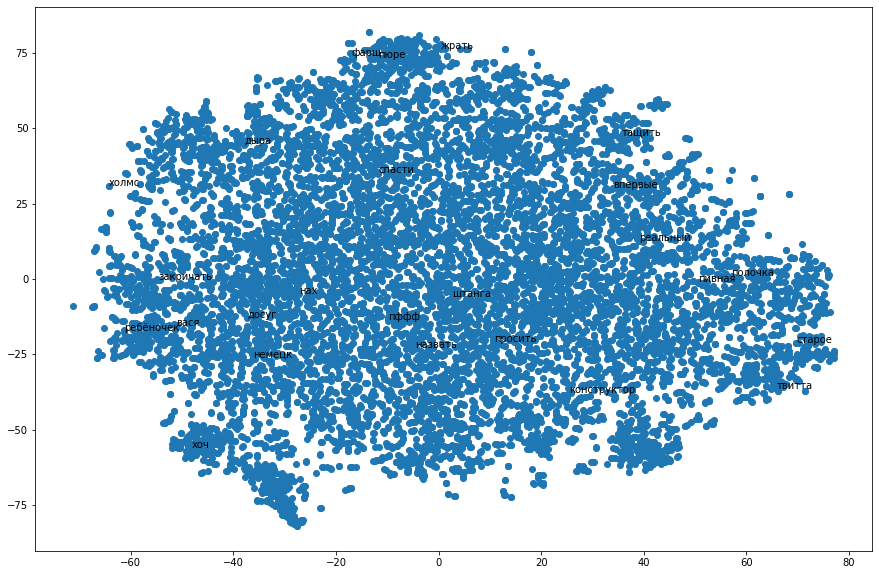

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


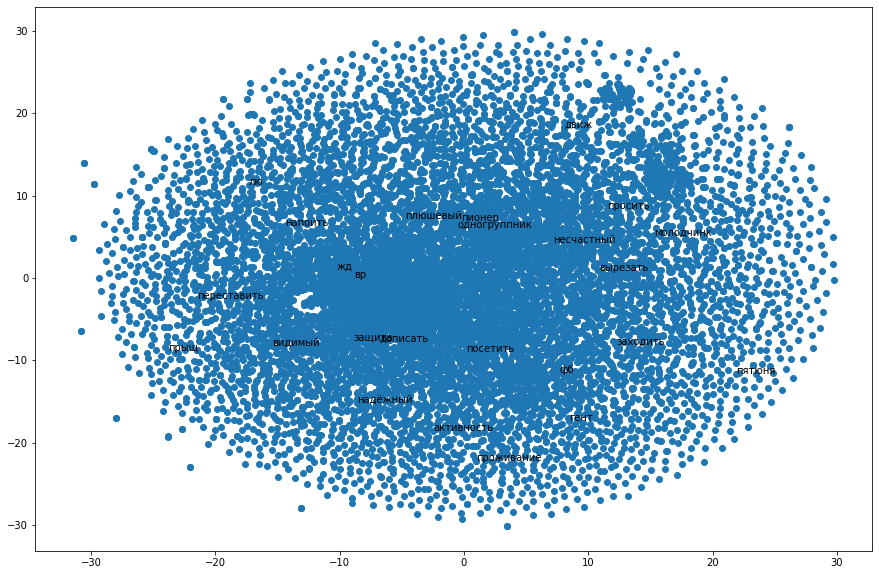

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


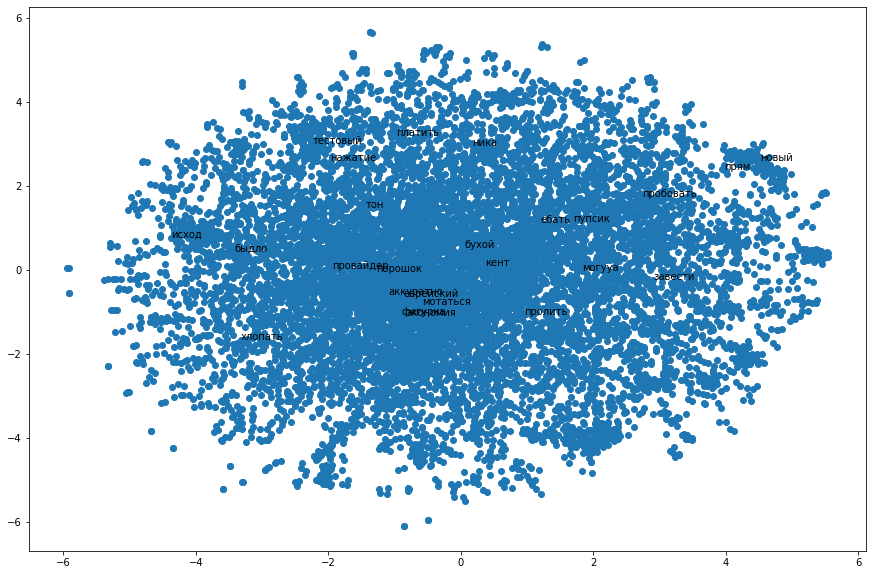

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


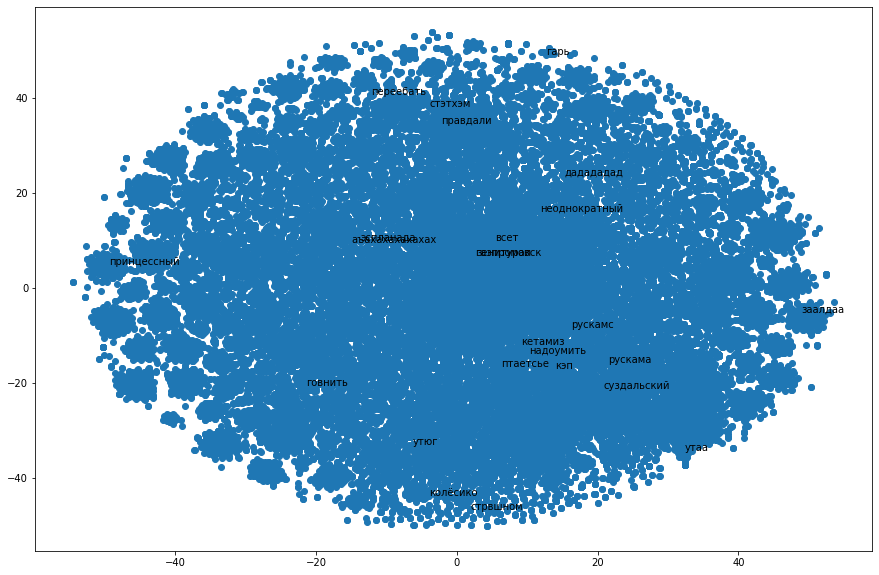

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


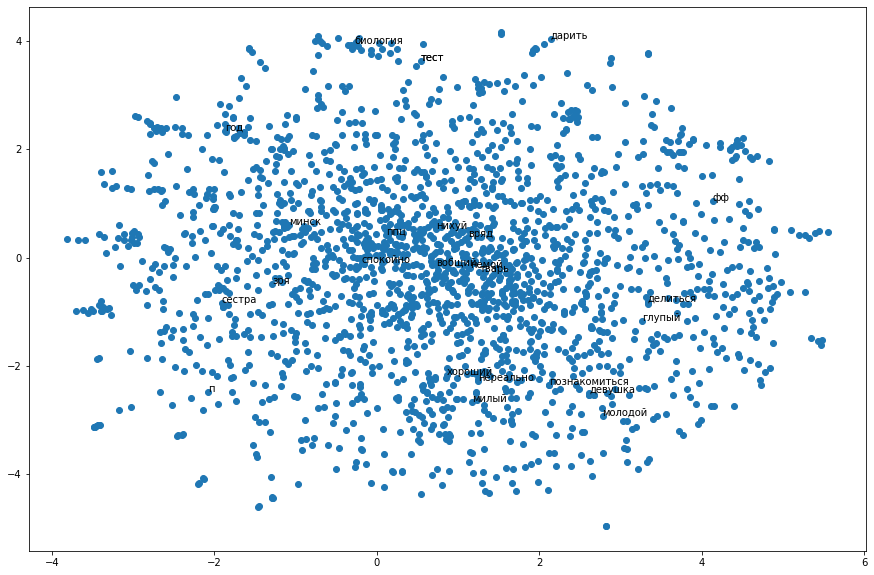

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (15, 10)


def reduce_dimensions(w2v_model):
    """Фукнция принимает модель word2vec и возвращает массив абсцисс,
    массив ординат и массив слов после снижения размерности"""
    tsne = TSNE(n_components=2, random_state=256)  # создадим экземпляр модели TSNE
    vectors = np.asarray(w2v_model.wv.vectors)     # возьмем из модели 300-мерный массив слов-векторов
    labels = np.asarray(w2v_model.wv.index2word)   # отдельно сохраним соответствие номера вектора и самого слова
    vectors = tsne.fit_transform(vectors)          # проведем преобразование каждого вектора в 2-мерный

    x = [v[0] for v in vectors]                    # запишем отдельно массив абсцисс и массив ординат
    y = [v[1] for v in vectors]
    return x, y, labels


def plot_w2v(w2v_model):
    """Функция строит график распределения слов по векторному пространству
    размерности 2 исходя из обученной модели word2vec"""
    x, y, labels = reduce_dimensions(w2v_model)                      # получим значения по осям и названия точек (исходные слова)
    plt.scatter(x, y)                                                # строим график с точками
    words_to_show_indices = np.random.randint(len(labels), size=25)  # выберем 25 случайных слов, которые отобразим на графике
    for i in words_to_show_indices:
        plt.annotate(labels[i], (x[i], y[i]))                        # для каждого из этих 25 слов отобразим текст на картинке
    plt.show()

plot_w2v(w2v_10_10)
plot_w2v(w2v_300_10)
plot_w2v(w2v_500_10)
plot_w2v(w2v_300_1)
plot_w2v(w2v_300_100)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


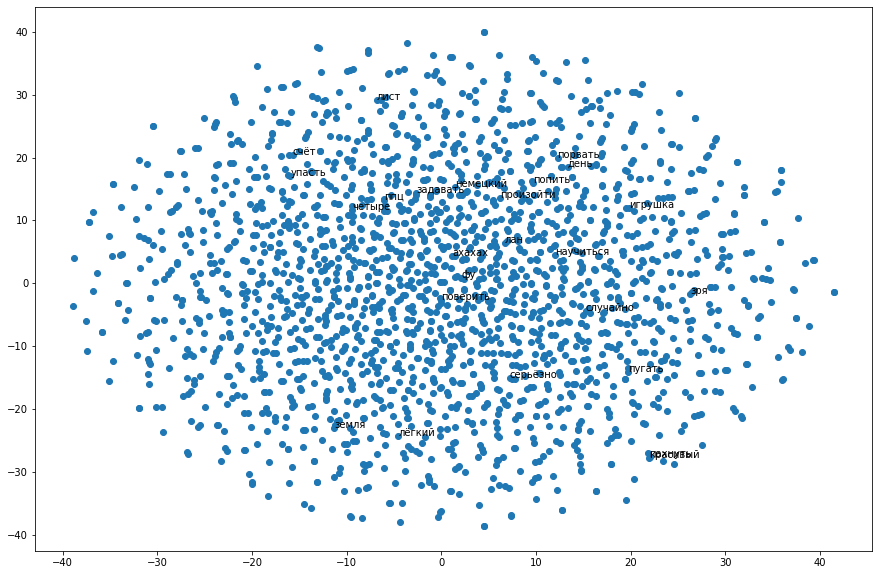

In [ ]:
plot_w2v(w2v_300_100)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


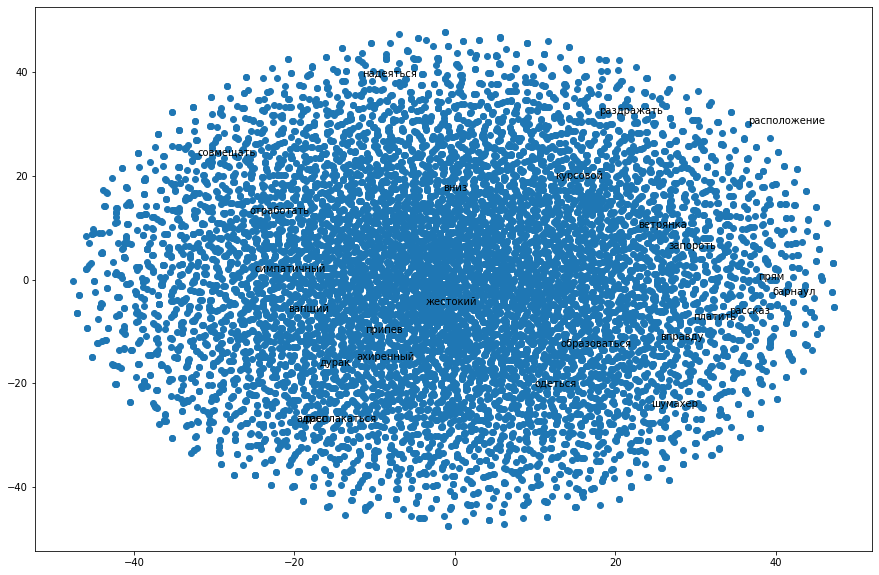

In [ ]:
plot_w2v(w2v_300_10)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


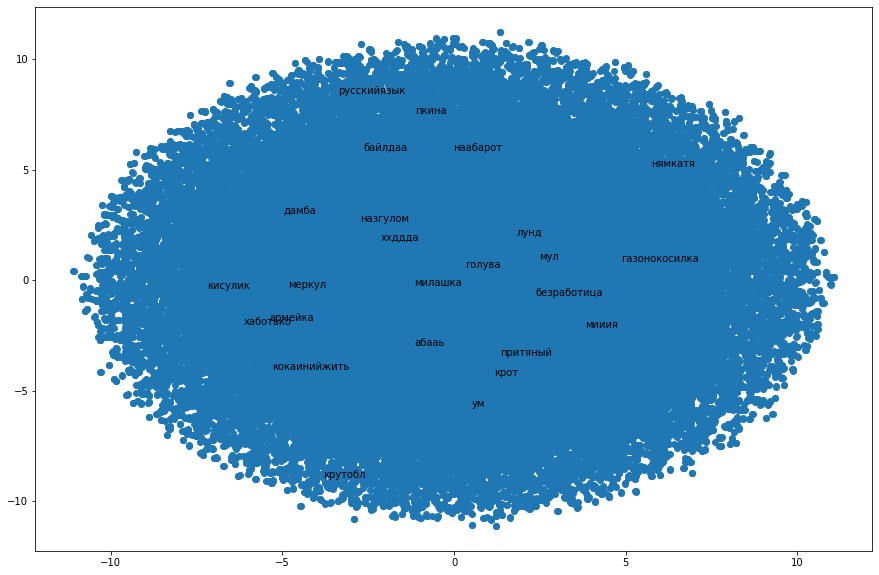

In [ ]:
plot_w2v(w2v_300_1)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


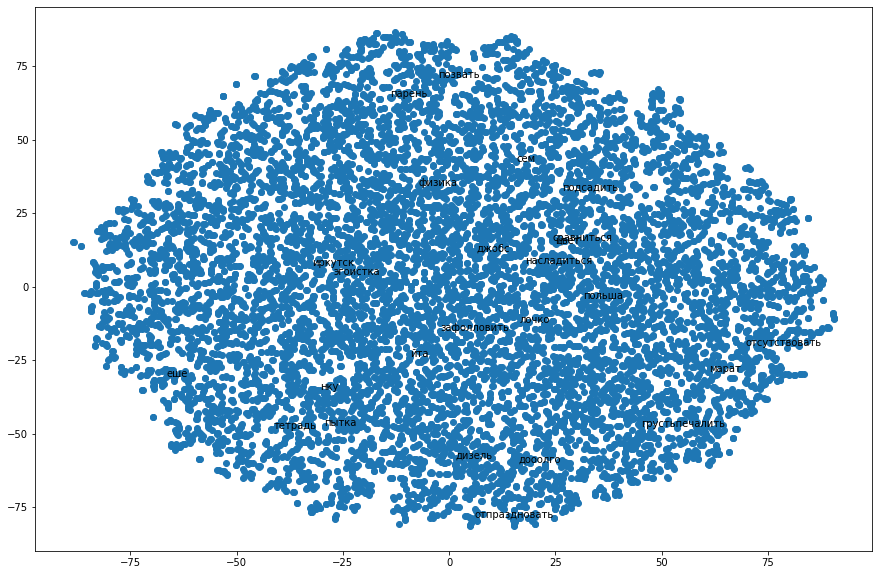

In [ ]:
plot_w2v(w2v_10_10)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


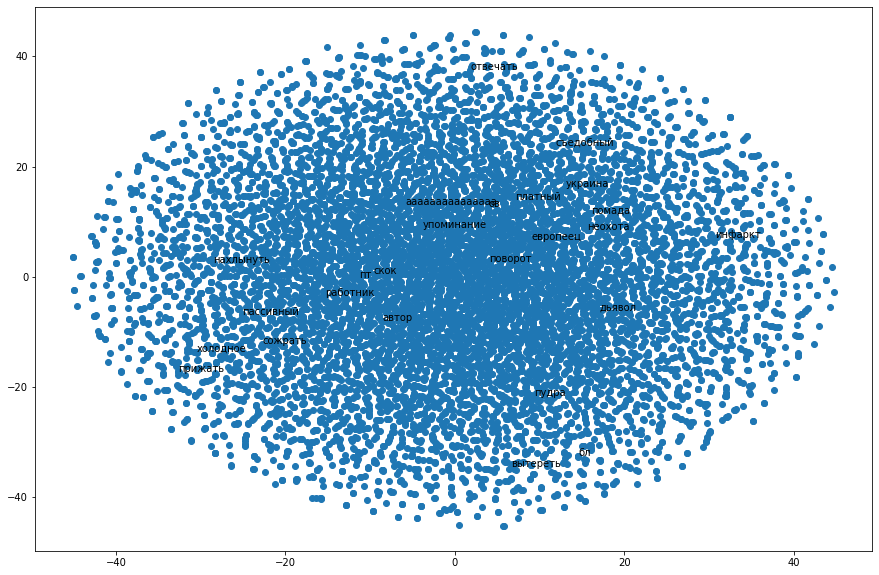

In [ ]:
plot_w2v(w2v_500_10)

## Вывод
Чем больше минимальная встречаемость слов, тем реже расположены точки на графике. Это происходит в первую очередь потому, что в рассчет берется меньшее количество слов.

Чем больше размер результирующего пространства, тем более явно наблюдается уплотнение точек ближе к центру. Это связано с тем, что с увеличением размера результирующего пространства повышается точность определения связей между словами. Большой размер результирующего пространства может вызывать переобученность.

###Обучим модель по умолчанию и попробуем предсказать продолжение твита "Такси везет меня на работу. Раздумываю приплатить"

In [ ]:
from gensim.models import Word2Vec

In [ ]:
w2v = Word2Vec(size=300, min_count=2) 
w2v.build_vocab(preprocessed_df.text)

In [ ]:
w2v.train(preprocessed_df.text, total_examples=preprocessed_df.shape[0], epochs=100)
w2v.predict_output_word(["такси", "везти", "работа"])

[('такси', 0.25289333),
 ('вызвать', 0.13180098),
 ('радио', 0.059022523),
 ('опаздывать', 0.052561447),
 ('доехать', 0.030321842),
 ('везти', 0.026360406),
 ('ехать', 0.019269526),
 ('сесть', 0.012095671),
 ('впереди', 0.0117446305),
 ('обратно', 0.009509269)]

In [ ]:
w2v.train(preprocessed_df.text, total_examples=preprocessed_df.shape[0], epochs=10)
w2v.predict_output_word(["такси", "везти", "работа"])

Чем больше эпох обучения, тем более точное предсказание дает модель.

# Задание 2

В этом задании от вас требуется провести классификацию текстов с использованием градиентного бустинга. Постройте такую модель, которая даст наилучший результат по метрике precision к классу 0, подобрав гиперпараметры:
- минимальная встречаемость слова в текстах в doc2vec
- максимальная глубина деревеьев в бустинге
- количество деревьев в бустинге

Дайте ответ на вопрос: лучше использовать более глубокие или более мелкие деревья в модели градиентного бустинга?

In [16]:
# Выполним все предварительные действия

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
!pip install xgboost

tweets = [TaggedDocument(doc, [i]) for i, doc in enumerate(preprocessed_df.text)]  # преобразуем наши тексты в объекты, понятные док-2-веку

# Разобьем набор текстов на тренировочную и тестовую выборки
X_train_texts, X_test_texts, y_train, y_test = train_test_split(preprocessed_df.text, preprocessed_df.positive, test_size=0.2, random_state=21)


###Попробуем разные модели doc2vec

In [ ]:
# Создадим модель Doc2Vec с минимальной встречаемостью слова 2
d2v = Doc2Vec(tweets, min_count=2)
d2v.train(tweets, total_examples=len(tweets), epochs=20)  # подберем веса коэффициентов внутри модели, которые больше будут подходить к нашему набору текстов

In [ ]:
def transform_text_array_to_vector_dataframe(text_array):
    """Функция, которая преобразует одномерную колонку списков слов из текстов
    в датафрейм со значениями векторов этих текстов"""
    columns = [str(n) for n in range(d2v.vector_size)]               # задаем список названий колонок - просто порядковые номера
    vectors_ndarray = text_array.apply(d2v.infer_vector).to_list()  # прогоняем каждый текст через модель doc2vec и формируем многомерный массив чисел
    return pd.DataFrame(vectors_ndarray, columns=columns)            # оборачиваем его в датафрейм для удобства


X_train = transform_text_array_to_vector_dataframe(X_train_texts)    # наконец создадим датафреймы, которые сможем подать в модель классификации
X_test = transform_text_array_to_vector_dataframe(X_test_texts)

In [ ]:
# Применим модель xgboost. Основные гиперпараметры: max_depth - максимальная глубина деревьев модели и n_estimators - количество деревьев.
# min_count=2, epochs=20

from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb = XGBClassifier(max_depth=10, n_estimators=50)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.63      0.63      0.63     22419
           1       0.64      0.64      0.64     22948

    accuracy                           0.63     45367
   macro avg       0.63      0.63      0.63     45367
weighted avg       0.63      0.63      0.63     45367



## Попроуем поменять параметр минимальная встречаемость слова в текстах в doc2vec

In [66]:
# Попробуем минимальную встречаемость 10
# min_count=10, epochs=20

d2v = Doc2Vec(tweets, min_count=10)
d2v.train(tweets, total_examples=len(tweets), epochs=20)

X_train10 = transform_text_array_to_vector_dataframe(X_train_texts)
X_test10 = transform_text_array_to_vector_dataframe(X_test_texts)

xgb.fit(X_train10, y_train)
y_pred = xgb.predict(X_test10)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.64      0.65      0.64     21969
           1       0.67      0.65      0.66     23398

    accuracy                           0.65     45367
   macro avg       0.65      0.65      0.65     45367
weighted avg       0.65      0.65      0.65     45367



In [67]:
# Попробуем минимальную встречаемость 100
# min_count=100, epochs=20

d2v = Doc2Vec(tweets, min_count=100)
d2v.train(tweets, total_examples=len(tweets), epochs=20)

X_train100 = transform_text_array_to_vector_dataframe(X_train_texts)
X_test100 = transform_text_array_to_vector_dataframe(X_test_texts)

xgb.fit(X_train100, y_train)
y_pred = xgb.predict(X_test100)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.63      0.66      0.65     21380
           1       0.68      0.66      0.67     23987

    accuracy                           0.66     45367
   macro avg       0.66      0.66      0.66     45367
weighted avg       0.66      0.66      0.66     45367



## Попробуем разные модели, меняя гиперпараметры максимальная глубина деревеьев в бустинге и количество деревьев в бустинге

In [19]:
# Применим параметры, общие для всех min_count=10, epochs=10

d2v = Doc2Vec(tweets, min_count=10)
d2v.train(tweets, total_examples=len(tweets), epochs=10)

X_train = transform_text_array_to_vector_dataframe(X_train_texts)
X_test = transform_text_array_to_vector_dataframe(X_test_texts)

In [21]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [22]:
xgb = XGBClassifier(max_depth=5, n_estimators=50)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.62      0.62      0.62     22394
           1       0.63      0.63      0.63     22973

    accuracy                           0.63     45367
   macro avg       0.63      0.63      0.63     45367
weighted avg       0.63      0.63      0.63     45367



In [69]:
xgb = XGBClassifier(max_depth=10, n_estimators=50)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.63      0.63      0.63     22419
           1       0.64      0.64      0.64     22948

    accuracy                           0.63     45367
   macro avg       0.63      0.63      0.63     45367
weighted avg       0.63      0.63      0.63     45367



In [23]:
xgb = XGBClassifier(max_depth=10, n_estimators=10)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.62      0.61      0.61     22634
           1       0.62      0.62      0.62     22733

    accuracy                           0.62     45367
   macro avg       0.62      0.62      0.62     45367
weighted avg       0.62      0.62      0.62     45367



In [70]:
xgb = XGBClassifier(max_depth=10, n_estimators=100)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.63      0.64      0.64     22224
           1       0.65      0.65      0.65     23143

    accuracy                           0.64     45367
   macro avg       0.64      0.64      0.64     45367
weighted avg       0.64      0.64      0.64     45367



## Вывод:

Лучше использовать более глубокие деревья в модели градиентного бустинга. Увеличение количества деревьев также улучшает результат